# Activity: Explore probability distributions

## **Introduction**

The ability to determine which type of probability distribution best fits data, calculate z-score, and detect outliers are essential skills in data work. These capabilities enable data professionals to understand how their data is distributed and identify data points that need further examination.

In this activity, you are a member of an analytics team for the United States Environmental Protection Agency (EPA). The data includes information about more than 200 sites, identified by state, county, city, and local site names. One of your main goals is to determine which regions need support to make air quality improvements. Given that carbon monoxide is a major air pollutant, you will investigate data from the Air Quality Index (AQI) with respect to carbon monoxide.

## **Step 1: Imports** 

Import relevant libraries, packages, and modules. For this lab, you will need `numpy`, `pandas`, `matplotlib.pyplot`, `statsmodels.api`, and `scipy`.

In [37]:
# Import packages
# Import the relevant Python libraries and modules needed in this lab.

### YOUR CODE HERE ###
# Import libraries and packages

# Import packages
from google.cloud import storage

import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
from io import StringIO
from io import BytesIO
import json
import pickle
import six
import charset_normalizer
from wordcloud import WordCloud 
from typing import List

from scipy import stats
import statsmodels.api as sm

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [4]:
#storage_client =  storage.Client.from_service_account_json('../heidless-jupyter-0-d2008100d98c.json')
storage_client =  storage.Client()

BUCKET_NAME = 'heidless-jupyter-bucket-0'

bucket = storage_client.get_bucket(BUCKET_NAME)

AllCSV = []
my_prefix = 'air-quality/'
my_file = 'modified_c4_epa_air_quality.csv'
full_file = my_prefix + my_file
#print(f'full_file: {full_file}')

file_names = list(bucket.list_blobs(prefix=my_prefix))
for file in file_names:
    if(file.name != my_prefix):
        if file.name == full_file:
            AllCSV.append(file.name)
#            print(file.name)
AllCSV


['air-quality/modified_c4_epa_air_quality.csv']

In [5]:
# RUN THIS CELL TO IMPORT YOUR DATA.

### YOUR CODE HERE ###
#companies = pd.read_csv("Unicorn_Companies.csv")

# Display the first 10 rows of the data
all_dataframes = []

for csv in AllCSV:
    blob = bucket.get_blob(csv)
    if blob is not None and blob.exists(storage_client):
        bt = blob.download_as_string()
        s = str(bt, 'ISO-8859-1')
        s = StringIO(s)
        df = pd.read_csv(s, encoding='ISO-8859-1', low_memory=False)

        #df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
        all_dataframes.append(df)
        print(csv)
    
#all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets

data = all_dataframes[0]
data.head()


air-quality/modified_c4_epa_air_quality.csv


,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,aqi_log
0,2018-01-01,Arizona,Maricopa,Buckeye,BUCKEYE,Carbon monoxide,Parts per million,2.079442
1,2018-01-01,Ohio,Belmont,Shadyside,Shadyside,Carbon monoxide,Parts per million,1.791759
2,2018-01-01,Wyoming,Teton,Not in a city,Yellowstone National Park - Old Faithful Snow ...,Carbon monoxide,Parts per million,1.098612
3,2018-01-01,Pennsylvania,Philadelphia,Philadelphia,North East Waste (NEW),Carbon monoxide,Parts per million,1.386294
4,2018-01-01,Iowa,Polk,Des Moines,CARPENTER,Carbon monoxide,Parts per million,1.386294


A subset of data was taken from the air quality data collected by the EPA, then transformed to suit the purposes of this lab. This subset is a .csv file named `modified_c4_epa_air_quality.csv`. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [ ]:
# RUN THIS CELL TO IMPORT YOUR DATA.

### YOUR CODE HERE ###
data = pd.read_csv("modified_c4_epa_air_quality.csv")


<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to what you learned about loading data in Python.
    
  
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

There is a function in the `pandas` library that allows you to load data from a .csv file into a DataFrame.
    
  
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

Use the `read_csv()` function and pass in the name of the csv file as a string.
    
</details>

## **Step 2: Data exploration** 

Display the first 10 rows of the data to get a sense of how the data is structured.

In [6]:
# Display first 10 rows of the data.

### YOUR CODE HERE ###
data.head()


,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,aqi_log
0,2018-01-01,Arizona,Maricopa,Buckeye,BUCKEYE,Carbon monoxide,Parts per million,2.079442
1,2018-01-01,Ohio,Belmont,Shadyside,Shadyside,Carbon monoxide,Parts per million,1.791759
2,2018-01-01,Wyoming,Teton,Not in a city,Yellowstone National Park - Old Faithful Snow ...,Carbon monoxide,Parts per million,1.098612
3,2018-01-01,Pennsylvania,Philadelphia,Philadelphia,North East Waste (NEW),Carbon monoxide,Parts per million,1.386294
4,2018-01-01,Iowa,Polk,Des Moines,CARPENTER,Carbon monoxide,Parts per million,1.386294


<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to what you learned about exploring datasets in Python.
    
  
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

There is a function in the `pandas` library that allows you to display a specific number of rows from the top of a DataFrame.
    
  
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

Use the `head()` function and pass in how many rows from the top of the DataFrame you want to display.
    
</details>

The `aqi_log` column represents AQI readings that were transformed logarithmically to suit the objectives of this lab. Taking a logarithm of the aqi to get a bell-shaped distribution is outside the scope of this course, but is helpful to see the normal distribution.

To better understand the quantity of data you are working with, display the number of rows and the number of columns.

In [8]:
# Display number of rows, number of columns.

### YOUR CODE HERE ###
data.shape


(260, 8)

<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to what you learned about exploring datasets in Python.
    
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

Every DataFrame in `pandas` has a property that gives you access to the number of rows and number of columns in that DataFrame.
  
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

Call the `shape` property of the DataFrame, which will display the number of rows and the number of columns as a tuple.
    
</details>

Now, you want to find out whether `aqi_log` fits a specific type of probability distribution. Create a histogram to visualize the distribution of `aqi_log`. Then, based on its shape, visually determine if it resembles a particular distribution.

<Axes: >

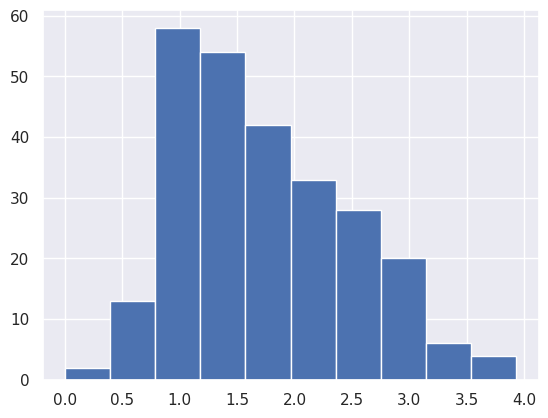

In [11]:
# Create a histogram to visualize distribution of aqi_log.

### YOUR CODE HERE ###
data['aqi_log'].hist()


<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video about creating a histogram to visualize the distribution of a particular variable in the data.
    
  
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

There is a function in the `matplotlib` library that can be called to create a histogram.
    
  
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

The `hist()` function can be called directly on the `aqi_log` column from the data. 

A semicolon can be used at the end as a quick way to make sure only the plot gets displayed (other text does not get displayed).
    
</details>

**Question:** What do you observe about the shape of the distribution from the histogram? 

[Write your response here. Double-click (or enter) to edit.]

## **Step 3: Statistical tests**

Use the empirical rule to observe the data, then test and verify that it is normally distributed.


 As you have learned, the empirical rule states that, for every normal distribution: 
- 68% of the data fall within 1 standard deviation of the mean
- 95% of the data fall within 2 standard deviations of the mean
- 99.7% of the data fall within 3 standard deviations of the mean


First, define two variables to store the mean and standard deviation, respectively, for `aqi_log`. Creating these variables will help you easily access these measures as you continue with the calculations involved in applying the empirical rule. 

In [16]:
# Define variable for aqi_log mean.

### YOUR CODE HERE ###
mean_aqi_log = data['aqi_log'].mean()


# Print out the mean.

### YOUR CODE HERE ###
aqi_log_mean


1.7669210929985582

In [17]:
# Define variable for aqi_log standard deviation.

### YOUR CODE HERE ###
std_aqi_log = data['aqi_log'].std()



# Print out the standard deviation.

### YOUR CODE HERE ###
std_aqi_log


0.7147155520223721

<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the lesson about calculating the mean and standard deviation for a particular variable in the data.
    
  
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

There are functions in the `numpy` library that can be called to calculate mean and standard deviation, respectively.
    
  
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

The `mean()` function can be called directly on the `aqi_log` column from the data to compute the mean.

The `std()` function can be called directly on the `aqi_log` column from the data to compute the standard deviation.
    
</details>

Now, check the first part of the empirical rule: whether 68% of the `aqi_log` data falls within 1 standard deviation of the mean.

To compute the actual percentage of the data that satisfies this criteria, define the lower limit (for example, 1 standard deviation below the mean) and the upper limit (for example, 1 standard deviation above the mean). This will enable you to create a range and confirm whether each value falls within it.

In [26]:
# Define variable for lower limit, 1 standard deviation below the mean.

### YOUR CODE HERE ###
lower_limit_1 = mean_aqi_log - 1 * std_aqi_log



# Define variable for upper limit, 1 standard deviation above the mean.

### YOUR CODE HERE ###
upper_limit_1 = mean_aqi_log + 1 * std_aqi_log




# Display lower_limit, upper_limit.

### YOUR CODE HERE ###
print(lower_limit_1)
print(upper_limit_1)


1.052205540976186
2.4816366450209304


<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video about using the empirical rule.
    
  
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

The lower limit here is $mean - 1 * std$.

The upper limit here is $mean + 1 * std$.

The `print` function can be called to display.
    
  
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

Use the variables that you defined for mean and standard deviation of `aqi_log`, ensuring the spelling is correct. 

Call the `print` function and pass in the values one after the other, with a comma between them.
    
</details>

In [24]:
# Display the actual percentage of data that falls within 1 standard deviation of the mean.

### YOUR CODE HERE ### 
((data['aqi_log'] >= lower_limit) & (data['aqi_log'] <= upper_limit)).mean() * 100


76.15384615384615

<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video about using the empirical rule.
    
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

The `>=` operator can be used to confirm whether one value is greater than or equal to another value.

The `<=` operator can be used to check whether one value is less than or equal to another value.

The `&` operator can be used to check if one condition and another condition is met. 
    
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

The `mean()` function can be used to compute the proportion of the data that satisfies the specified conditions. 

Multiplying that proportion by $100$ can get you the percentage.
    
</details>

Now, consider the second part of the empirical rule: whether 95% of the `aqi_log` data falls within 2 standard deviations of the mean.

To compute the actual percentage of the data that satisfies this criteria, define the lower limit (for example, 2 standard deviations below the mean) and the upper limit (for example, 2 standard deviations above the mean). This will enable you to create a range and confirm whether each value falls within it.

In [28]:
# Define variable for lower limit, 2 standard deviations below the mean.

### YOUR CODE HERE ###

lower_limit_2 = mean_aqi_log - 2 * std_aqi_log



# Define variable for upper limit, 2 standard deviations below the mean.

### YOUR CODE HERE ###
upper_limit_2 = mean_aqi_log + 2 * std_aqi_log




# Display lower_limit, upper_limit.

### YOUR CODE HERE ###
print(lower_limit_2)
print(upper_limit_2)


0.3374899889538139
3.1963521970433026


<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video about using the empirical rule.
    
  
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

The lower limit here is $mean - 2 * std$.

The upper limit here is $mean + 2 * std$.

The `print` function can be called to display.
    
  
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

Use the variables that you defined for mean and standard deviation of `aqi_log`, ensuring the spelling is correct. 

Call the `print` function and pass in the values one after the other, with a comma between them.
    
</details>

In [31]:
# Display the actual percentage of data that falls within 2 standard deviations of the mean.

### YOUR CODE HERE ### 
((data['aqi_log'] >= lower_limit_2) & (data['aqi_log'] <= upper_limit_2)).mean() * 100


95.76923076923077

<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video section about using the empirical rule.
    
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

The `>=` operator can be used to confirm whether one value is greater than or equal to another value.

The `<=` operator can be used to check whether one value is less than or equal to another value.

The `&` operator can be used to check if one condition and another condition is met. 
    
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

The `mean()` function can be used to compute the proportion of the data that satisfies the specified conditions. 

Multiplying that proportion by $100$ can get you the percentage.
    
</details>

Now, consider the third part of the empirical rule:whether 99.7% of the `aqi_log` data falls within 3 standard deviations of the mean.

To compute the actual percentage of the data that satisfies this criteria, define the lower limit (for example, 3 standard deviations below the mean) and the upper limit (for example, 3 standard deviations above the mean). This will enable you to create a range and confirm whether each value falls within it.

In [34]:
# Define variable for lower limit, 3 standard deviations below the mean.

### YOUR CODE HERE ###
lower_limit_3 = mean_aqi_log - 3 * std_aqi_log



# Define variable for upper limit, 3 standard deviations above the mean.

### YOUR CODE HERE ###
upper_limit_3 = mean_aqi_log + 3 * std_aqi_log

# Display lower_limit, upper_limit.

### YOUR CODE HERE ###
print(lower_limit_3)
print(upper_limit_3)


-0.37722556306855815
3.9110677490656744


<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video about using the empirical rule.
    
  
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

The lower limit here is $mean - 3 * std$.

The upper limit here is $mean + 3 * std$.

The `print` function can be called to display.
    
  
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

Use the variables that you defined for mean and standard deviation of `aqi_log`, ensuring the spelling is correct. 

Call the `print` function and pass in the values one after the other, with a comma between them.
    
</details>

In [35]:
# Display the actual percentage of data that falls within 3 standard deviations of the mean.

### YOUR CODE HERE ### 
((data['aqi_log'] >= lower_limit_3) & (data['aqi_log'] <= upper_limit_3)).mean() * 100



99.61538461538461

<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video about using the empirical rule.
    
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

The `>=` operator can be used to confirm whether one value is greater than or equal to another value.

The `<=` operator can be used to check whether one value is less than or equal to another value.

The `&` operator can be used to check if one condition and another condition is met. 
    
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

The `mean()` function can be used to compute the proportion of the data that satisfies the specified conditions. 

Multiplying that proportion by $100$ can get you the percentage.
    
</details>

## **Step 4: Results and evaluation** 

**Question:** What results did you attain by applying the empirical rule? 

[Write your response here. Double-click (or enter) to edit.]

**Question:** How would you use z-score to find outliers? 

[Write your response here. Double-click (or enter) to edit.]

Compute the z-score for every `aqi_log` value. Then, add a column named `z_score` in the data to store those results. 

In [38]:
# Compute the z-score for every aqi_log value, and add a column named z_score in the data to store those results.

### YOUR CODE HERE ###
data['Z_SCORE'] = stats.zscore(data['aqi_log'])

# Display the first 5 rows to ensure that the new column was added.

### YOUR CODE HERE ###

data.head()

,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,aqi_log,Z_SCORE
0,2018-01-01,Arizona,Maricopa,Buckeye,BUCKEYE,Carbon monoxide,Parts per million,2.079442,0.438109
1,2018-01-01,Ohio,Belmont,Shadyside,Shadyside,Carbon monoxide,Parts per million,1.791759,0.034820
2,2018-01-01,Wyoming,Teton,Not in a city,Yellowstone National Park - Old Faithful Snow ...,Carbon monoxide,Parts per million,1.098612,-0.936873
3,2018-01-01,Pennsylvania,Philadelphia,Philadelphia,North East Waste (NEW),Carbon monoxide,Parts per million,1.386294,-0.533584
4,2018-01-01,Iowa,Polk,Des Moines,CARPENTER,Carbon monoxide,Parts per million,1.386294,-0.533584


<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video about calculating z-score.
    
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

There is a function in the `stats` module of the `scipy` library that you can call to calculate z-score.
    
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

Call the `zscore()` function and pass in the `aqi` column from the data.
    
</details>

Identify the parts of the data where `aqi_log` is above or below 3 standard deviations of the mean.

In [48]:
# Display data where `aqi_log` is above or below 3 standard deviations of the mean

### YOUR CODE HERE ###
data[(data["Z_SCORE"] > 3) | (data["Z_SCORE"] < -3)]


,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,aqi_log,Z_SCORE
244,2018-01-01,Arizona,Maricopa,Phoenix,WEST PHOENIX,Carbon monoxide,Parts per million,3.931826,3.034886


<details><summary><h4><strong>Hint 1</strong></h4></summary>

Refer to the video about outlier detection.
    
</details>

<details><summary><h4><strong>Hint 2</strong></h4></summary>

The `>` operator can be used to evaluate whether one value is greater than another value. 

The `<` operator can be used to evaluate whether one value is less than another value. 

The `|` operator can used to evaluate whether one condition or another condition is met.  
    
</details>

<details><summary><h4><strong>Hint 3</strong></h4></summary>

To index the DataFrame, place a pair of parantheses around the evaluation of the two conditions and pass that into a pair of square brackets. This will allow you to get all rows in the data where the specified criteria is met.

Make sure the spelling of the column matches the name you specified when creating that column. 
    
</details>

**Question:** What do you observe about potential outliers based on the calculations?


[Write your response here. Double-click (or enter) to edit.]

**Question:** Why is outlier detection an important part of this project? 

[Write your response here. Double-click (or enter) to edit.]

## **Considerations**

**What are some key takeaways that you learned during this lab?**

[Write your response here. Double-click (or enter) to edit.]

**What summary would you provide to stakeholders? Consider the distribution of the data and which sites would benefit from additional research.**

[Write your response here. Double-click (or enter) to edit.]

**Reference**

US EPA, OAR. 2014, July 8. [Air Data: Air Quality Data Collected at Outdoor Monitors Across the US](https://www.epa.gov/outdoor-air-quality-data). 

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.